# Field Analysis Deep Dive
This workbook will walk through the method of field analysis on a step-by-step basis to explain the underlying method. Most of this behavior is programmed into `field.compute_projected_position`, but it may be instructive to describe the steps in more detail. Some references will be made to the accompanying research article (J. Ranalli and W. Hobbs, PV Plant Equipment Labels and Layouts can be Validated by Analyzing Cloud Motion in Existing Plant Measurements, submitted 2023).

To begin, we read in and initialize the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from solartoolbox import spatial, field, signalproc

datafile = "data/sample_plant_2.h5"
pos_utm = pd.read_hdf(datafile, mode="r", key="utm")

ts_data_a = pd.read_hdf(datafile, mode="r", key="data_a")
ts_data_b = pd.read_hdf(datafile, mode="r", key="data_b")

cmv_a = spatial.pol2rect(9.52, 0.62)
cmv_b = spatial.pol2rect(8.47, 2.17)


C:\Users\jar339\AppData\Local\Temp\ipykernel_3388\4130361253.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


The data that we've read has a few different components. The first is the position of the combiners, which is stored in the `pos_utm` dataframe. This dataframe has the following columns:
- `E` - The eastward position of the combiner's centroid in UTM coordinates
- `N` - The northward position of the combiner's centroid in UTM coordinates

The second component is the dataframes for the two one hour periods. These dataframes consist of a single column for each combiner containing the time series for a one hour period period during which the cloud motion vector was relatively constant. The CMVs are manually specified here to save on computational time, with `cmv_a` corresponding to `data_a` and so on.  

## Calculation Process
The calculation is carried out for a single combiner at a time. We will term this combiner of interest the target, $P_1$. Our goal is to compute a prediction, $P'_1$, of the target's location. The process is as follows:
1. Isolate time period of a fixed CMV, $V_A$. 
2. Compute the delay, $\tau_{A,i}$, between target time series and that for each other combiner, $P_{2,i}$. 
3. Convert the delays to a distance along the CMV.
4. Compute the error vector, $e_{A,i}$, between the inferred location of the target and its actual location.
5. Perform averaging (usually using downselection) to compte a representative $e_A$ for the while CMV.
6. Repeat 1-5 for a second CMV, $V_B$, to obtain a second error vector, $e_B$.
7. Compute the intersection of the two error vectors to obtain the inferred location of the target, $P'_1$.
8. Repeat 1-7 for each target combiner.

## Finding the Delays
In this implementation, we perform step 2 that by looking at the transfer function between $P_1$ and $P_{2,i}$ and finding the delay from the phase of the transfer function. The box below shows an example of the transfer function for a single pair of sensors, for a single CMV to demonstrate.

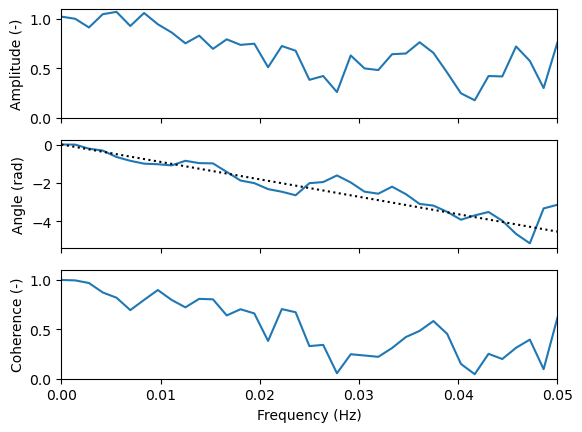

In [2]:
pt1 = 'CMB-015-1'
pt2 = 'CMB-015-6'
sig_in, sig_out = ts_data_a[pt1], ts_data_a[pt2]

# Calculate the TF
tf, coh = signalproc.averaged_tf(sig_in, sig_out, navgs=5, overlap=0.5, window='hamming', detrend=None)

# Calculate the delay and a simulated TF with that delay
delay = signalproc.tf_delay(tf, coh, coh_limit=0.6, freq_limit=0.02)[0]
fitline = signalproc.apply_delay(tf * 0 + 1, delay)

# Plot the results
fig, axs = plt.subplots(3,1, sharex=True)
axs[0].plot(tf.index, np.abs(tf))
axs[0].set_ylabel('Amplitude (-)')
axs[0].set_ylim([0, 1.1])
axs[1].plot(tf.index, np.unwrap(np.angle(tf),axis=0))
axs[1].plot(tf.index, np.unwrap(np.angle(fitline)), 'k:')
axs[1].set_ylabel('Angle (rad)')
axs[2].plot(tf.index, coh)
axs[2].set_ylabel('Coherence (-)')
axs[2].set_ylim([0,1.1])
axs[2].set_xlim([0, 0.05])
axs[2].set_xlabel('Frequency (Hz)')
plt.show()

In order to complete all the delays in the entire field, a convenience function is provided in the `field` module. This function is entitled `field.compute_delays` and is used by the method to compute delays between $P_1$ and each possible $P_{2,i}$ all at once. 


## Converting to Distances and Computing Error Vectors
We convert the delay into an apparent distance between $P_1$ and each $P_{2,i}$, which represents the projection of the vector from $P_1$ to $P'_{2,i}$ onto the CMV direction. As before, we designate this with a prime to indicate that it is derived from the cloud motion $D'_{||,A}$.This is done using the following equation.
$$V * \tau = D'_{||,A}$$ 

The error vector represents the difference between the sites' positions inferred from the cloud motion and those as expected from the site plans. We calculate the site plan separation distances, $D_{||,A}$, by computing a vector between each point pair and projecting onto the CMV axes.

Given $D_{||,A}$ and $D'_{||,A}$, we then compute the error vectors according to equation 2 in the paper.
$$e_{A} = D'_{||,A} - D_{||,A}$$



In [3]:
ref = 'CMB-021-5'
combined_data = []

# Work on a single CMV at a time
for df, cmv in zip([ts_data_a, ts_data_b], [cmv_a, cmv_b]):

    # Get the pairwise delays
    delay, coh = field.compute_delays(df, ref, navgs=5, coh_limit=0.6, freq_limit=0.02)

    # Convert them to distances along the cloud motion vector
    delay_dist = -delay * spatial.magnitude(cmv)

    # Compute the site-plan separation distance for comparison
    pos_vecs = -spatial.compute_vectors(pos_utm['E'], pos_utm['N'], pos_utm.loc[ref][['E', 'N']])  # negative for pair->ref
    plan_dist = spatial.project_vectors(pos_vecs, cmv)  # project onto CMV dir

    # Compute the Error Vector for each point pair
    error_dist = delay_dist - plan_dist['dist']

    # Compile the results
    pos_data = pd.DataFrame({'plan_dist': plan_dist['dist'],
                             'delay_dist': delay_dist,
                             'error_dist': error_dist,
                             'delay': delay,
                             'coh': coh},
                            index=pos_utm.index)
    combined_data.append(pos_data)

## Delay Visualization
It can be useful to visualize the delay over the entire plant relative to the indicated reference for each CMV. This is shown below for the two CMVs. The arrow origin indicates the reference point and the direction represents the CMV axis. Note that some points that would intuitively exhibit delay show a value of zero. This is due to issues with quality control (i.e. poor coherence between the signals), and demonstrates that points that are too far apart may not produce good results due to poor relationship between the sensor pairs. This is handled by downselecting points in subsequent steps.  

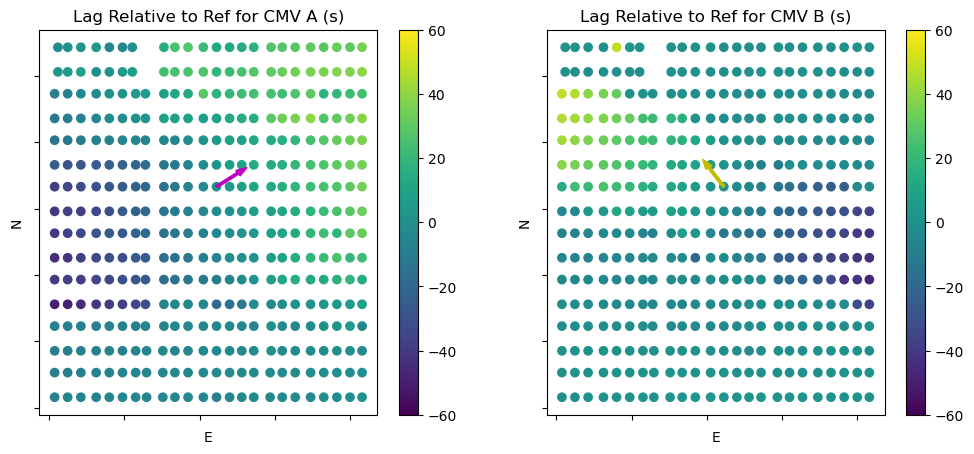

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for ax, dat, cmv, lbl, arrowcolor in zip(axs, combined_data, [cmv_a, cmv_b], ['A','B'], ['m','y']):
    f = ax.scatter(pos_utm['E'], pos_utm['N'], c=dat['delay'], cmap='viridis')
    vscale = 100
    velvec = np.array(spatial.unit(cmv)) * vscale
    ax.arrow(pos_utm['E'][ref], pos_utm['N'][ref], velvec[0], velvec[1], length_includes_head=True, width=7, head_width=20, color=arrowcolor)
    cb = plt.colorbar(f)
    f.set_clim(-60, 60)
    ax.set_xlabel('E')
    ax.set_ylabel('N')
    ax.set_title(f'Lag Relative to Ref for CMV {lbl} (s)')
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])

## Averaging the error vectors
As mentioned, the previous code computed an error vector for every possible site-pair combination in the variable `combined_data[i]['error_dist']`. However, many of the site-pairs are so far apart that the relationship between them is quite poor, meaning that the delays calculated may be highly uncertain. We only want to use the points with the best possible relationship, so that we have high confidence in the predicted positions. Many methods could be used for this in principle, but here, we downselected to the 8 points for each CMV that had the highest low-frequency coherence in the transfer function. The magnitudes of the error vectors, $e_{A,i}$, for these 8 points were averaged, resulting in an average error vector position, $e_A$ of the sensor along each CMV.

The plots below show the 8 points that were used for each CMV, in this case.

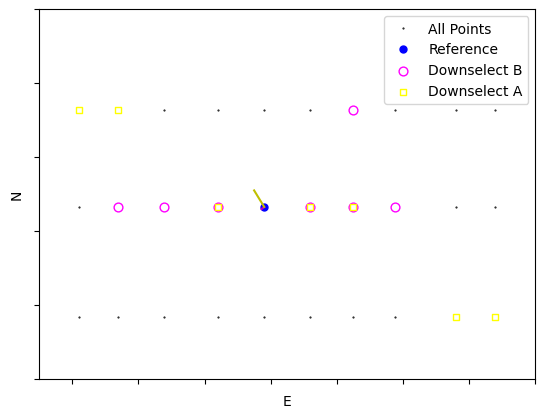

In [5]:
ndownsel = 8
coh1 = combined_data[0]['coh']
ix1 = coh1.sort_values().iloc[-ndownsel:-1].index
coh2 = combined_data[1]['coh']
ix2 = coh2.sort_values().iloc[-ndownsel:-1].index
combined_data_subset = [combined_data[0].loc[ix1], combined_data[1].loc[ix2]]
e_a = np.mean(combined_data_subset[0]['error_dist']) * spatial.unit(cmv_a)
e_b = np.mean(combined_data_subset[1]['error_dist']) * spatial.unit(cmv_b)

# Plotting
plt.plot(pos_utm['E'], pos_utm['N'], 'k.', markersize=1, zorder=0)
plt.plot(pos_utm['E'][ref], pos_utm['N'][ref], 'b.', markersize=10, zorder=1)
plt.scatter(pos_utm['E'].loc[ix1], pos_utm['N'].loc[ix1], s=40, edgecolors='magenta', marker='o', facecolors='white', zorder=2)
plt.scatter(pos_utm['E'].loc[ix2], pos_utm['N'].loc[ix2], s=15, edgecolors='yellow', facecolors='white', marker='s', zorder=3)
plt.plot([pos_utm['E'][ref], pos_utm['E'][ref]+e_a[0]],[pos_utm['N'][ref],pos_utm['N'][ref]+e_a[1]], 'm-')
plt.plot([pos_utm['E'][ref], pos_utm['E'][ref]+e_b[0]],[pos_utm['N'][ref],pos_utm['N'][ref]+e_b[1]], 'y-')
plt.legend(['All Points', 'Reference', 'Downselect B', 'Downselect A'])
plt.xlim([275,650])
plt.ylim([550,800])
ax = plt.gca()
ax.set_xlabel('E')
ax.set_ylabel('N')
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([]);

## Computing the 2-D Position
From the inferred error vectors $e_A$ and $e_B$, we can now compute the predicted location of the target point in 2-D space, $P'_1$. This is done by finding the intersection of lines perpendicular to the two error vectors, and is implemented in `spatial.compute_intersection`. Since the predicted position is computed by considering the location of the target point as the origin, we then shift the position by the expected location of the reference point to obtain its absolute position.

The following plots show $e_A$, $e_B$ and $P'_1$ in relation to the target point $P_1$. The left plot is zoomed out to show the relationship with the combiner spacing, while the right plot shows a detailed view. The dotted lines show the perpendicular projections from the error vectors to the predicted location, which lies at their intersection. The dashed blue line and the red star shows the distance between $P_1$ and the predicted $P'_1$. As the position shown for the combiner is relatively close to $P_1$, we would probably interpret this combiner position as validated.  

The absolute distance between  P1 and P'1 is 13.81 m.


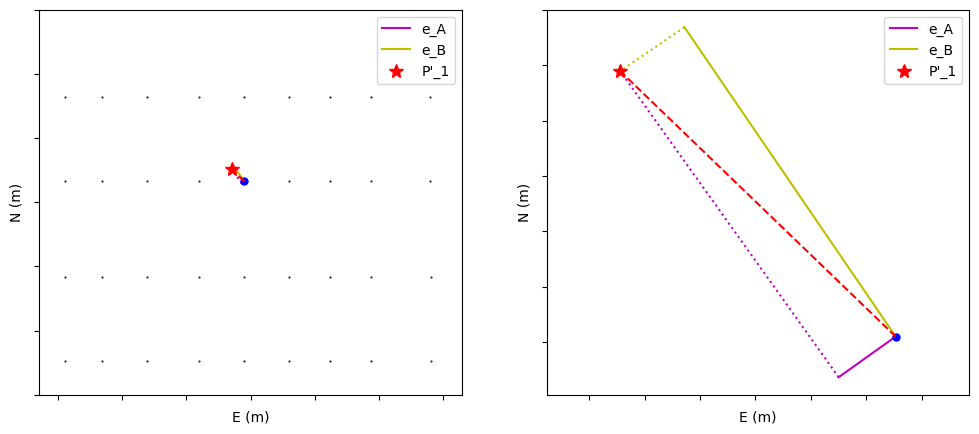

In [6]:
pos = spatial.compute_intersection(np.expand_dims(e_a, axis=0), np.expand_dims(e_b, axis=0))
print(f"The absolute distance between  P1 and P'1 is {spatial.magnitude(pos.flatten()):0.2f} m.")
pred_pos = (pos + pos_utm.loc[ref].values).flatten()

# Plotting
fig, axs = plt.subplots(1,2, figsize=(12,5))
axs[0].plot([pos_utm['E'][ref], pos_utm['E'][ref]+e_a[0]],[pos_utm['N'][ref],pos_utm['N'][ref]+e_a[1]], 'm-')
axs[0].plot([pos_utm['E'][ref], pos_utm['E'][ref]+e_b[0]],[pos_utm['N'][ref],pos_utm['N'][ref]+e_b[1]], 'y-')
axs[0].plot(pred_pos[0], pred_pos[1], 'r*', markersize=10, zorder=2)
axs[0].plot([pos_utm['E'][ref]+e_a[0],pred_pos[0]], [pos_utm['N'][ref]+e_a[1], pred_pos[1]], 'm:', zorder=0)
axs[0].plot([pos_utm['E'][ref]+e_b[0],pred_pos[0]], [pos_utm['N'][ref]+e_b[1], pred_pos[1]], 'y:', zorder=0)
axs[0].plot(pos_utm['E'], pos_utm['N'], 'k.', markersize=1, zorder=0)
axs[0].plot(pos_utm['E'][ref], pos_utm['N'][ref], 'b.', markersize=10, zorder=2)
axs[0].plot(np.array([pos_utm['E'][ref], pred_pos[0]]), np.array([pos_utm['N'][ref], pred_pos[1]]), 'r--', zorder=2)
axs[0].legend(['e_A', 'e_B', "P'_1"])
axs[0].axis('equal')
axs[0].set_xlim([400,500])
axs[0].set_ylim([500,800])
axs[0].set_xlabel('E (m)')
axs[0].set_ylabel('N (m)')
axs[0].xaxis.set_ticklabels([])
axs[0].yaxis.set_ticklabels([])

axs[1].plot([pos_utm['E'][ref], pos_utm['E'][ref]+e_a[0]],[pos_utm['N'][ref],pos_utm['N'][ref]+e_a[1]], 'm-')
axs[1].plot([pos_utm['E'][ref], pos_utm['E'][ref]+e_b[0]],[pos_utm['N'][ref],pos_utm['N'][ref]+e_b[1]], 'y-')
axs[1].plot(pred_pos[0], pred_pos[1], 'r*', markersize=10, zorder=2)
axs[1].plot([pos_utm['E'][ref]+e_a[0],pred_pos[0]], [pos_utm['N'][ref]+e_a[1], pred_pos[1]], 'm:', zorder=0)
axs[1].plot([pos_utm['E'][ref]+e_b[0],pred_pos[0]], [pos_utm['N'][ref]+e_b[1], pred_pos[1]], 'y:', zorder=0)
axs[1].plot(pos_utm['E'][ref], pos_utm['N'][ref], 'b.', markersize=10, zorder=2)
axs[1].plot(np.array([pos_utm['E'][ref], pred_pos[0]]), np.array([pos_utm['N'][ref], pred_pos[1]]), 'r--', zorder=2)
axs[1].legend(['e_A', 'e_B', "P'_1"])
axs[1].axis('equal')
axs[1].set_xlabel('E (m)')
axs[1].set_ylabel('N (m)')
axs[1].xaxis.set_ticklabels([])
axs[1].yaxis.set_ticklabels([]);
